# Bootstrap 01 - A tutorial

#### Josep Fortiana 2019-10-29

The _bootstrap_ is a generic name for a family of computationally intensive procedures in Statistics based on generating from a single dataset a collection of simulated datasets _(resamples),_ from which it is possible to infer information about the stochastic mechanism that originated the dataset.

### 1. Resamples and _Out-Of-Bag_ observations

A  _resample_ from a set $x$ of $n$ observations is a sample of size $n$ of elements from $x$, extracted with replacement, that is, after each extraction, the extracted element is replaced to the set and can be chosen again. Thus a given element $x_1$ can appear more than once in the resample (also it may happen it does not appear). Example:

In [1]:
set.seed(24025)
x<-1:12
n<-length(x)
x1<-sample(x,n,replace = TRUE)
x1

[1]  6  4  6  2  3  9  7  6 10  6  4 10

Each resample contains $n$ elements, the same as the original set $x$. Some elements appear twice or more, while other elements of $x$ do not appear. El conjunto de observaciones que no aparece se suele llamar _OOB (Out-of-bag)._ Podemos detectarlas haciendo:

In [2]:
oob<-x[is.na(match(x,x1))]
oob

[1]  1  5  8 11 12

## 2. An example of a simple bootstrap

### Failures of Air-conditioning Equipment

Proschan (1963) reported on the times $T$ in hours, between failures of the air-conditioning equipment in 10 Boeing 720 aircraft. The following dataset also apears as `aircondit` in the `boot` package. It contains the intervals for the ninth aircraft.

In [3]:
t<-c(3,5,7,18,43,85,91,98,100,130,230,487)
n<-length(t)

We want to study $T$. 

For instance, to decide with a given significance level $\alpha=0.05$, whether the expected value $\tau=\operatorname{E}(T)$ is less than $\tau_{0}=110$ hours, the specification in the maintainance and repair contract.

The observed empirical average $\overline{t}$ is:

In [4]:
t.bar<-mean(t)
round(t.bar,4)

[1] 108.0833

### Classical approach to the problem

Steps:

- 1. Try and find some (known) probability distribution to model this dataset and, eventually, perform a goodness-of-fit test.

- 2. Estimate parameters (if any) in the given distribution.

- 3. Devise a hypotheses test of $\overline{T}<\tau_{0}$ versus $\overline{T}\geq\tau_{0}$, in particular designing (finding) a test statistic $Z$ as a function of the sample, deriving its probability distribution and, by means of it, select an acceptance region $\{Z\in A_{1}\}$.

- 4. Finally, for the observed sample, compute the observed value $z$ of $Z$ and take the appropriate decision.

#### Histogram

Loading required package: MASS


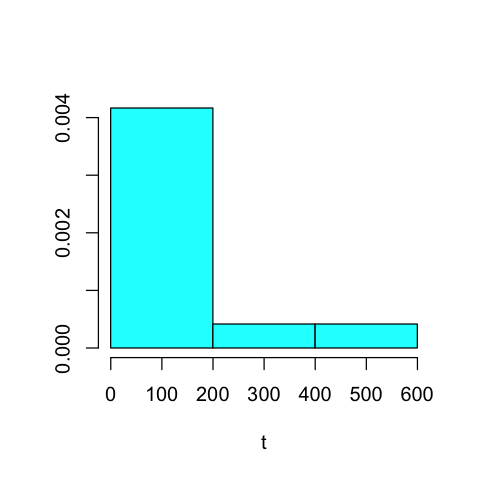

In [5]:
require(MASS)
options(repr.plot.width=4,repr.plot.height=4)
truehist(t)

The shape bears a close resemblance to an exponential distribution.

$$
    f(t|\lambda)=\lambda\,\exp\{-\lambda\,t\},
    \quad t>0, \quad \lambda>0.
$$

In an exponential model $\operatorname{Exp}(\lambda)$ the maximum likelihood estimator of $\tau=1/\lambda$ is the empirical average $\overline{t}=108.0833$.

#### QQ plot

Visually compare the empirical (observed) distribution to the theoretical one, $\operatorname{Exp}(\lambda)$. 

Should there be a good agreement, points in the plot would lie on the line.

Exercise: do the same for a small data set generated from some given distribution. 

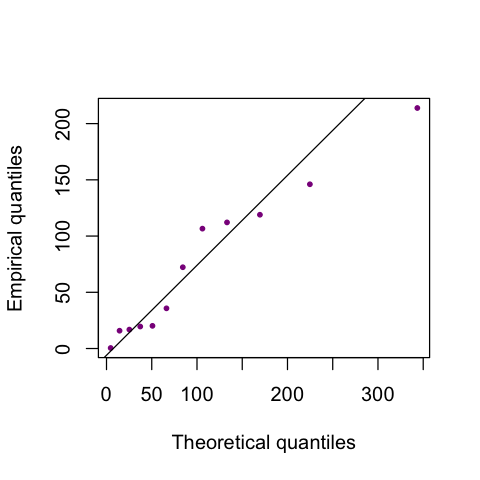

In [15]:
# Generate a sample of n=12 values from an exponential distribution with lambda=1/t.bar and obtain its QQplot
#
#
a<-qexp(ppoints(12), rate=1/t.bar)
s<-rexp(12,rate=1/t.bar)
qqplot(a,s,pch=19,cex=0.5,col="DarkMagenta",
    xlab="Theoretical quantiles",ylab="Empirical quantiles")
qqline(s,distribution=function(p){qexp(p,rate=1/t.bar)})

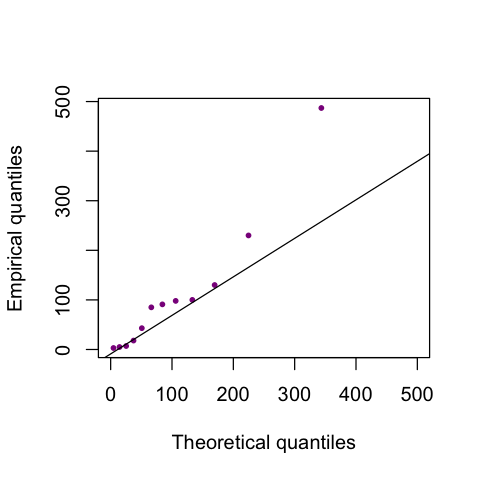

In [16]:
options(repr.plot.width=4,repr.plot.height=4)
qqplot(qexp(ppoints(12),rate=1/t.bar),t,xlim=c(0,500),pch=19,cex=0.5,col="DarkMagenta",
    xlab="Theoretical quantiles",ylab="Empirical quantiles")
qqline(t,distribution=function(p){qexp(p,rate=1/t.bar)})

Kolmogorov-Smirnov goodness-of-fit test to check whether we can accept the exponential model.

In [17]:
ks.test(t,pexp,1/t.bar)


	One-sample Kolmogorov-Smirnov test

data:  t
D = 0.18729, p-value = 0.7282
alternative hypothesis: two-sided


Accepting the exponential model, and from the property that a sum of independent exponential variates with the same parameter $\tau=1/\lambda$,
    
$$
    Z=\sum_{i=1}^{n}T_{i}
$$
  
follows a  $\operatorname{Gamma}(n,1/\tau)$ distribution, we use this distribution to make inference about $\tau$.

For the observed sample,

In [18]:
z<-sum(t)
round(z,2)

[1] 1297

and the critical $p$-value to decide on the null hypothesios $H_{0}:\tau<\tau_{0}=110$ is:

In [19]:
tau.0<-110
p.val<-1-pgamma(z,shape=n,scale=tau.0)
round(p.val,3)

[1] 0.486

### _Bootstrap_ approach to the same problem

We generate a number $N$ of \emph{resamples}, each of them of equal length $n=12$ as the observed sample $t$.

Each resample is obtained by selecting $n$ elements of the set $t$ with equal probability $1/n$ and _with replacement._

For any statistic $U\equiv U(t)$, function of the sample $t$, the collection of $N$ values resulting from applying it to the collection of $N$ resamples is the _bootstrap sample_ of $U$:

$$
    u_{1},\dots,u_{N}.
$$

In [20]:
# A function to generate resamples, returning a matrix with a resample in each row:
resample<-function(x,N){
    n<-length(x)
    X<-matrix(0,nrow=N,ncol=n)
    for (i in 1:N){
        X[i,]<-sample(x,n,replace = TRUE)
        }
    return(X)
    }

For instance we generate $N=1000$ resamples of the air conditioning data and, for each of them we compute the arithmetic mean:

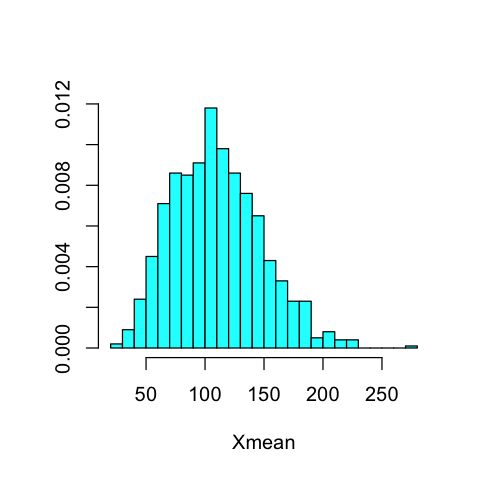

In [26]:
X<-resample(t,1000)
Xmean<-apply(X,1,mean)
options(repr.plot.width=4,repr.plot.height=4)
truehist(Xmean)

The bootstrap-empirical $p$-value, $p^{\star}$, is the relative frequency (proportion) within the bootstrap sample `Xsum` of values greater than the actually observed value $z=1297$.

In [27]:
Xsum<-apply(X,1,sum)
p.star<-sum(Xsum>z)/1000
round(p.star,3)

[1] 0.491

Other more complicated statistics such as the coefficient of variation $\operatorname{CV}=\sigma/\mu$, the ratio of the standard deviation $\sigma$, whose theoretical distribution appears unthinkable to derive, can be studied in the same way within the bootstrap 0framework.

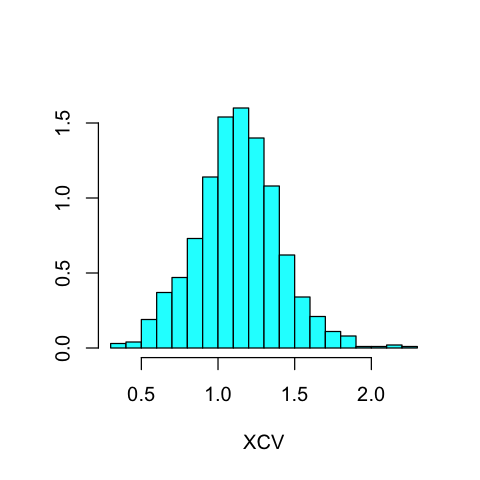

In [28]:
X<-resample(t,1000)
Xmean<-apply(X,1,mean)
Xsd<-apply(X,1,sd)
XCV<-Xsd/Xmean
options(repr.plot.width=4,repr.plot.height=4)
truehist(XCV)

## 3. Example of bootstrap in ISLR, pp. 189-191

In [29]:
#install.packages("ISLR",dependencies=TRUE,repos="https://cloud.r-project.org")
require(ISLR)
#install.packages("boot",dependencies=TRUE,repos="https://cloud.r-project.org")
require(boot)

Loading required package: ISLR
Loading required package: boot


### `Portfolio` dataset

#### Description

A simple simulated data set containing 100 returns for each of two assets, X and Y. The data is used to estimate the optimal fraction to invest in each asset to minimize investment risk of the combined portfolio. One can then use the Bootstrap to estimate the standard error of this estimate.

#### Format

A data frame with 100 observations on the following 2 variables.

01. `X`: Returns for Asset X

02. `Y`: Returns for Asset Y

#### Source

Simulated data

In [16]:
data(Portfolio)
str(Portfolio)

'data.frame':	100 obs. of  2 variables:
 $ X: num  -0.895 -1.562 -0.417 1.044 -0.316 ...
 $ Y: num  -0.235 -0.885 0.272 -0.734 0.842 ...


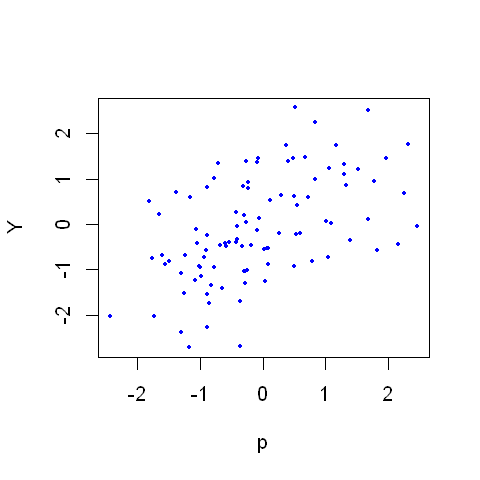

In [17]:
options(repr.plot.width=4,repr.plot.height=4)
plot(Portfolio,"p",pch=19,col="blue",cex=0.4)

In [18]:
# Proportion of X for a two assets portfolio with a minimum risk (minimum variance)
alpha.fn=function(data,index){
 X=data$X[index]
 Y=data$Y[index]
 return((var(Y)-cov(X,Y))/(var(X)+var(Y)-2*cov(X,Y)))
 }
alpha0<-alpha.fn(Portfolio,1:100)
round(alpha0,3)

[1] 0.576

In [19]:
# ---- SNIP ---- SNIP ---- SNIP ---- 
# W=Var/(sigma.Y^2); rho=sigma.XY/(sigma.X*sigma.Y); t =sigma.X/sigma.Y
W<-function(alpha,rho,t){
    return(alpha^2*t^2+(1-alpha)^2+2*alpha*(1-alpha)*rho*t)
    }

alpha.max<-function(rho,t){
    return((1-rho*t)/(1+t^2-2*rho*t))
    }

In [20]:
index<-1:100
X=Portfolio$X[index]
Y=Portfolio$Y[index]
sigma.X<-sqrt(var(X))
sigma.Y<-sqrt(var(Y))
t<-sigma.X/sigma.Y
rho<-cor(X,Y)
alpha.hat<-alpha.max(rho,t)
round(sigma.X,3)
round(sigma.Y,3)
round(t,3)
round(alpha.hat,3)

[1] 1.062

[1] 1.144

[1] 0.929

[1] 0.576

In [21]:
W.rho.t<-function(rho,t){
    
}

In [22]:
set.seed(1)
alpha.fn(Portfolio,sample(100,100,replace=TRUE))

[1] 0.7368375

In [23]:
boot(Portfolio,alpha.fn,R=1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Portfolio, statistic = alpha.fn, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.5758321 -0.001695873  0.09366347

## 4. _Bootstrap_ in evaluating prediction methods

There are several ways of using _bootstrap_ in evaluating prediction models. A sensible procedure is, for each resample in a sufficiently large collection of $N$ generated resamples, use the resample itself as the _train_ subset and the _OOB_  subset (individuals in the original sample not present in the resample) as _test_ subset. 

Then the _bootstrap estimate of the prediction error,_  `E.boot`, is the average of the $N$ error proportions.

#### Efron's $0.632$ rule

The _naif_ procedure, to use the same set both as `train`and `test`, yields another estimate `E.subst`, which has an optimistic bias, due to the fact that the test data are in a way already known by the prediction algorithm. On the other hand, it is known that `E.boot` has a pessimistic bias.

Bradley Efron, the discoverer of bootstrap, proposed the idea to use a weighted mean of both estimators, as a way of compensating both biases. This is explained in two articles, Efrom (1983), _Estimating the Error Rate of a Prediction Rule: Improvement on Cross-Validation,_ and Efron (1997) _Improvements on Cross-Validation: The .632+ Bootstrap Method._ 

The $0.632$ rule described there, is to use the estimate `E.632` defined as:

$$
    E.632 = 0.632 * E.boot_{1} + 0.368 * E.subst,
$$

where $E.boot_{1}$ is a _leave-one-out bootstrap estimator,_ slightly different from the $E.boot$ described above. The motivation for using $0.632$ as the weight comes from the approximate computation of the probability that a given individual in a sample of $n$ appears in a resample:

$$
			 1-(1-1/n)^n \approx 1-1/e =0.6321206. 
$$